In [205]:
import numpy as np
import pandas as pd
from urllib.request import urlopen
import certifi
import ssl
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
context = ssl.create_default_context(cafile=certifi.where())




In [206]:
def set_values(s,e):
    start=s
    end=e
    return start,end
start,end=set_values(1997,2024)
print(start)
    

1997


In [207]:
# define urls for per game and advanced stats
#extracting data from site
def get_data(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table')
    
 
    data = []
    if url[-13:]=="advanced.html":
        headers = [th.text.strip() for th in table.find_all('th') if th.text.strip()!=""][7:]
        for tr in table.find_all('tr')[1:]:
            if str(tr)[:16]=="<tr class=\"thead" or str(tr)[:16]=="<tr class=\"itali":
                continue
            row = np.array([td.text.strip() for td in tr.find_all('td')[6:] if "DUMMY" not in str(td)])
            data.append(row)
    else:
        headers = [th.text.strip() for th in table.find_all('th')]
        
        for tr in table.find_all('tr')[1:]:
            
            if str(tr)[:16]=="<tr class=\"thead"or str(tr)[:16]=="<tr class=\"itali" :
                
                if data[-1][4]=="TOT":
                    data[-1][4]=[td.text.strip() for td in tr.find_all('td') ][3]
                    
                continue
            
            
            row = np.append([0],np.array([td.text.strip() for td in tr.find_all('td') ]))
            
            
            data.append(row)
          
    headers=headers[:row.size]
    arr=np.array(data)
      

    return arr,headers

#creating data frame

per_game_url = 'https://www.basketball-reference.com/leagues/NBA_{}_per_game.html'
advanced_url = 'https://www.basketball-reference.com/leagues/NBA_{}_advanced.html'
def data_frame():
    for i in range(start,end+1):
        per_game_for_seas,per_game_headers=get_data(per_game_url.format(i))
        per_game_for_seas=np.insert(per_game_for_seas,3,i,axis=1)
        advanced_for_seas,adnvanced_headers=get_data(advanced_url.format(i))
        temp_full=np.concatenate((per_game_for_seas,advanced_for_seas),axis=1)
        if i==1997:
            full=temp_full
        else:
            full=np.concatenate((full,temp_full))
        print(i)
        
    whole_data=pd.DataFrame(full)
    headers=np.concatenate((per_game_headers,adnvanced_headers))
    headers=np.insert(headers, 3,"Season")
    whole_data.columns=headers
    whole_data.Rk=[i for i in range(1,len(full)+1)]
    return whole_data

   
   

In [208]:
whole_data=data_frame()


nba_abbreviations_teams = {
    'PHO': 'Phoenix Suns',
    'WSB':'Washington Wizards',
    'ATL': 'Atlanta Hawks',
    'BOS': 'Boston Celtics',
    'BKN': 'Brooklyn Nets',
    'BRK':'Brooklyn Nets',
    'CHO':'Charlotte Hornets',
    'CHH': 'Charlotte Hornets',
    'NOK': 'New Orleans Pelicans',
    'CHI': 'Chicago Bulls',
    'CLE': 'Cleveland Cavaliers',
    'DAL': 'Dallas Mavericks',
    'DEN': 'Denver Nuggets',
    'DET': 'Detroit Pistons',
    'GSW': 'Golden State Warriors',
    'HOU': 'Houston Rockets',
    'IND': 'Indiana Pacers',
    'LAC': 'Los Angeles Clippers',
    'LAL': 'Los Angeles Lakers',
    'MEM': 'Memphis Grizzlies',
    'MIA': 'Miami Heat',
    'MIL': 'Milwaukee Bucks',
    'MIN': 'Minnesota Timberwolves',
    'NOP': 'New Orleans Pelicans',
    'NYK': 'New York Knicks',
    'OKC': 'Oklahoma City Thunder',
    'ORL': 'Orlando Magic',
    'PHI': 'Philadelphia 76ers',
    'PHX': 'Phoenix Suns',
    'POR': 'Portland Trail Blazers',
    'SAC': 'Sacramento Kings',
    'SAS': 'San Antonio Spurs',
    'TOR': 'Toronto Raptors',
    'UTA': 'Utah Jazz',
    'WAS': 'Washington Wizards',
    'CHA': 'Charlotte Hornets', # Became Charlotte Hornets in 2014
    'NJN': 'New Jersey Nets',   # Moved to Brooklyn and became Brooklyn Nets in 2012
    'NOH': 'New Orleans Hornets', # Became New Orleans Pelicans in 2013
    'SEA': 'Seattle SuperSonics', # Relocated to Oklahoma City and became Oklahoma City Thunder in 2008
    'VAN': 'Memphis Grizzlies', # Relocated to Memphis and became Memphis Grizzlies in 2001
}
whole_data.to_csv("whole_data.csv")




1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024


In [209]:

#splitting the data to numerical and personal
numerical_data=pd.DataFrame(whole_data.values[:,6:],columns=whole_data.columns[6:])

p_id=pd.DataFrame(np.zeros((whole_data.shape[0],8)),columns=["Rk","Player","team", "season","Age","seed","cons_mvp","mvp_votes"])
p_id.Rk=whole_data.Rk
p_id.Age=whole_data.Age
p_id.Player=whole_data.Player
p_id.season=whole_data.Season
p_id.team=whole_data.Tm



In [211]:
#filling the standings
def givehtml(s):
    wikiurl="https://en.wikipedia.org/wiki/{}%E2%80%93{}_NBA_season"
    if s<2009 and s>=1999:
        page=urlopen(wikiurl.format(str(s),"0"+str((s+1)%100)))
    
    else:
        page=urlopen(wikiurl.format(str(s),str((s+1)%100)))
    htmllang=page.read()
    htmlstr=htmllang.decode("utf-8")
    

    return htmlstr


    
def cut_data(htmlstr):
    
    startEastv1=htmlstr.index("<span class=\"mw-headline\" id=\"By_conference\">By conference</span>")
    startEast=htmlstr[startEastv1:].index("season")+1+startEastv1
    finishEast=htmlstr[startEast:].index("West")+startEast
    startWest=finishEast
    finishWest=htmlstr[startWest:].index("Playoffs")+startWest
    east_data=htmlstr[startEast:finishEast]
    west_data=htmlstr[startWest:finishWest]

    return east_data,west_data


def get_stands(results,start,end):
    for i in range(start-1,end):
     
        east_data,west_data=cut_data(givehtml(i))
        res_dictionary={}
        #east
       
        start=east_data.find("season")
        n=30
        while start >= 0 and n > 1:
            start = east_data.find("season", start+1)
            if n%2==0:
                  sign=east_data[start:].find("<")+start
                  res_dictionary[east_data[start+8:sign]]=int((32-n)/2)
            n -= 1
        
        #west
        if i>=2004:
            start=west_data.find("season")
            n=30
            while start >= 0 and n > 1:
                start = west_data.find("season", start+1)
                if n%2==0:
                  sign=west_data[start:].find("<")+start
                  res_dictionary[west_data[start+8:sign]]=int((32-n)/2)
                n-=1
        else:
            n=28
            start=west_data.find("season")
      
            while start >= 0 and n > 1:
                start = west_data.find("season", start+1)
                if n%2==0:
                  sign=west_data[start:].find("<")+start
                  res_dictionary[west_data[start+8:sign]]=int((30-n)/2)
                n-=1
        results.append(res_dictionary)        

     
    
        
#changing past team names
results=[] 
get_stands(results,start,end)


for i in results:
    try:
       val=i["Washington Bullets"]
       del i["Washington Bullets"]
       i["Washington Wizards"]=val
    except:
         pass
    
    try:
        val=i['Vancouver Grizzlies']
        del i['Vancouver Grizzlies']
        i['Memphis Grizzlies']=val
    except:pass
    try:
        val=i['Charlotte Bobcats']
        del i['Charlotte Bobcats']
        i['Charlotte Hornets']=val
    except:pass
    try:
        val=i['New Orleans/Oklahoma City Hornets']
        del i['New Orleans/Oklahoma City Hornets']
        i['New Orleans Pelicans']=val
    except:pass
    
   
#seeding
for i,v in enumerate(p_id.values):
       
    
            p_id.at[i,"seed"]=float(results[int(v[3])-start][nba_abbreviations_teams[v[2]]])
#in case i didn't want to do the mvp voting data part(only for current year)
if p_id.shape[0]<1000:
    combined=pd.DataFrame(np.concatenate((p_id.values,numerical_data),axis=1),columns=np.append(p_id.columns,numerical_data.columns))
    combined.to_csv("23-24data.csv")    
            
       
        

        




In [212]:
#scraping data
def get_mvp_vote_data(url,mvp_data_storage):
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table')
 
    this_year_votes={}
    current=""
    column=0
    for td in table.find_all('td'):
        
        if column%19==0:
            current=td.text.strip()
        elif column%19==6:
            points=float(td.text.strip())
            this_year_votes[current]=points
        column+=1
    mvp_data_storage.append(this_year_votes)

mvp_votes_url="https://www.basketball-reference.com/awards/awards_{}.html"
def gather_mvp_voting(start,end):
    mvp_data_storage=[]
    for i in range(start,end+1):
        get_mvp_vote_data(mvp_votes_url.format(i),mvp_data_storage)
    return mvp_data_storage
        
mvp_voting_data=gather_mvp_voting(start,2023)
print(mvp_voting_data)

[{'Karl Malone': 0.857, 'Michael Jordan': 0.832, 'Grant Hill': 0.327, 'Tim Hardaway': 0.207, 'Glen Rice': 0.117, 'Gary Payton': 0.091, 'Hakeem Olajuwon': 0.083, 'Patrick Ewing': 0.05, 'Anthony Mason': 0.006, "Shaquille O'Neal": 0.006, 'Scottie Pippen': 0.005, 'Alonzo Mourning': 0.004, 'Dikembe Mutombo': 0.003, 'Mitch Richmond': 0.003, 'John Stockton': 0.003, 'Charles Barkley': 0.002, 'Tom Gugliotta': 0.001, 'Allen Iverson': 0.001, 'Kevin Johnson': 0.001, 'Steve Smith': 0.001}, {'Michael Jordan': 0.934, 'Karl Malone': 0.726, 'Gary Payton': 0.372, "Shaquille O'Neal": 0.268, 'Tim Duncan': 0.128, 'Tim Hardaway': 0.061, 'David Robinson': 0.031, 'Vin Baker': 0.021, 'Grant Hill': 0.02, 'Scottie Pippen': 0.012, 'Glen Rice': 0.006, 'Antoine Walker': 0.005, 'Jason Kidd': 0.004, 'John Stockton': 0.004, 'Mitch Richmond': 0.003, 'Reggie Miller': 0.002, 'Rik Smits': 0.002, 'Michael Finley': 0.001, 'Rod Strickland': 0.001}, {'Karl Malone': 0.701, 'Alonzo Mourning': 0.655, 'Tim Duncan': 0.627, 'Allen 

In [215]:
cur_year=0.0
mvp=""
cons=0.0
for i,v in enumerate(p_id.values):
    if p_id.at[i,"season"]=="2024":
        break
    
    if p_id.at[i,"Player"][-1]=="*":
        p_id.at[i,"Player"]= p_id.at[i,"Player"][:-1]
        
    
    if p_id.at[i,"season"]!=cur_year:
        cur_year=v[3]
        cur_year_data=mvp_voting_data[int(cur_year)-start]
        
        max_val=max(cur_year_data.values())
        
    if p_id.at[i,"Player"] in cur_year_data.keys():
    
        p_id.at[i,"mvp_votes"]=cur_year_data[p_id.at[i,"Player"]]
        
       
        if p_id.at[i,"mvp_votes"]==max_val:
            if p_id.at[i,"Player"]== mvp:
                print(p_id.at[i,"Player"])
                cons+=1
            else:
                cons=0
            mvp=p_id.at[i,"Player"]
            p_id.at[i,"cons_mvp"]=cons




p_id.to_csv("p_id.csv")

Tim Duncan
Steve Nash
LeBron James
LeBron James
Stephen Curry
Giannis Antetokounmpo
Nikola Jokić


In [216]:
combined

,Rk,Player,team,season,Age,seed,cons_mvp,mvp_votes,G,GS,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Mahmoud Abdul-Rauf,SAC,1997,0.346154,0.571429,0.0,0.0,0.880952,0.614458,...,0.108,0.262741,0.292818,0.168317,0.214286,0.493022,0.253820,0.319172,0.267724,0.152778
1,2,Shareef Abdur-Rahim,VAN,1997,0.076923,0.928571,0.0,0.0,0.940476,0.855422,...,0.135,0.312571,0.276243,0.217822,0.223214,0.490920,0.257920,0.315904,0.270117,0.194444
2,3,Rafael Addison,CHH,1997,0.538462,0.357143,0.0,0.0,0.476190,0.036145,...,0.112,0.227633,0.193370,0.108911,0.111607,0.490728,0.247111,0.320261,0.262339,0.166667
3,4,Cory Alexander,SAS,1997,0.192308,0.857143,0.0,0.0,0.940476,0.072289,...,0.211,0.251416,0.209945,0.158416,0.142857,0.488243,0.257920,0.330065,0.273706,0.215278
4,5,Jerome Allen,IND,1997,0.230769,0.642857,0.0,0.0,0.892857,0.012048,...,0.214,0.176670,0.165746,0.178218,0.111607,0.485567,0.247484,0.336601,0.267724,0.173611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13381,13382,Thaddeus Young,TOR,2024,0.653846,0.785714,0.0,0.0,0.261905,0.072289,...,0.107,0.142695,0.220994,0.128713,0.138393,0.508889,0.255684,0.348584,0.277296,0.194444
13382,13383,Trae Young,ATL,2024,0.269231,0.642857,0.0,0.0,0.583333,0.602410,...,0.159,0.345413,0.397790,0.138614,0.285714,0.503154,0.275438,0.313725,0.283578,0.333333
13383,13384,Omer Yurtseven,UTA,2024,0.269231,0.714286,0.0,0.0,0.345238,0.072289,...,0.213,0.194790,0.171271,0.128713,0.093750,0.483273,0.240030,0.327887,0.259049,0.166667
13384,13385,Cody Zeller,NOP,2024,0.500000,0.357143,0.0,0.0,0.416667,0.000000,...,0.160,0.137033,0.198895,0.138614,0.120536,0.502198,0.244875,0.343137,0.266826,0.173611


In [217]:
combined=pd.DataFrame(np.concatenate((p_id.values,numerical_data),axis=1),columns=np.append(p_id.columns,numerical_data.columns))

for i in combined:
    if i not in ["Rk","season","team","Player"] :
        for k,n in enumerate(combined[i]):
                if n=="":
                        combined.at[k,i]=0.0
             
for i in combined:
         if i not in ["Rk","season","team","Player"]:
                
                    combined[i]=np.array(combined[i], dtype=float)
                    combined[i]=np.array((combined[i]-min(combined[i]))/(max(combined[i])-min(combined[i])))
               

                


In [218]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
X=combined.drop(["cons_mvp","mvp_votes"],axis=1).values
y=combined.mvp_votes.values

In [219]:
combined

,Rk,Player,team,season,Age,seed,cons_mvp,mvp_votes,G,GS,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Mahmoud Abdul-Rauf,SAC,1997,0.346154,0.571429,0.0,0.0,0.880952,0.614458,...,0.108,0.262741,0.292818,0.168317,0.214286,0.493022,0.253820,0.319172,0.267724,0.152778
1,2,Shareef Abdur-Rahim,VAN,1997,0.076923,0.928571,0.0,0.0,0.940476,0.855422,...,0.135,0.312571,0.276243,0.217822,0.223214,0.490920,0.257920,0.315904,0.270117,0.194444
2,3,Rafael Addison,CHH,1997,0.538462,0.357143,0.0,0.0,0.476190,0.036145,...,0.112,0.227633,0.193370,0.108911,0.111607,0.490728,0.247111,0.320261,0.262339,0.166667
3,4,Cory Alexander,SAS,1997,0.192308,0.857143,0.0,0.0,0.940476,0.072289,...,0.211,0.251416,0.209945,0.158416,0.142857,0.488243,0.257920,0.330065,0.273706,0.215278
4,5,Jerome Allen,IND,1997,0.230769,0.642857,0.0,0.0,0.892857,0.012048,...,0.214,0.176670,0.165746,0.178218,0.111607,0.485567,0.247484,0.336601,0.267724,0.173611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13381,13382,Thaddeus Young,TOR,2024,0.653846,0.785714,0.0,0.0,0.261905,0.072289,...,0.107,0.142695,0.220994,0.128713,0.138393,0.508889,0.255684,0.348584,0.277296,0.194444
13382,13383,Trae Young,ATL,2024,0.269231,0.642857,0.0,0.0,0.583333,0.602410,...,0.159,0.345413,0.397790,0.138614,0.285714,0.503154,0.275438,0.313725,0.283578,0.333333
13383,13384,Omer Yurtseven,UTA,2024,0.269231,0.714286,0.0,0.0,0.345238,0.072289,...,0.213,0.194790,0.171271,0.128713,0.093750,0.483273,0.240030,0.327887,0.259049,0.166667
13384,13385,Cody Zeller,NOP,2024,0.500000,0.357143,0.0,0.0,0.416667,0.000000,...,0.160,0.137033,0.198895,0.138614,0.120536,0.502198,0.244875,0.343137,0.266826,0.173611


In [223]:

label_encoder = LabelEncoder()
x_categorical = combined.select_dtypes(include=['object']).apply(label_encoder.fit_transform)
x_numerical = combined.select_dtypes(exclude=['object']).values
x = pd.concat([pd.DataFrame(x_numerical), x_categorical], axis=1).values
 
# Fitting Random Forest Regression to the dataset
regressor = RandomForestRegressor(n_estimators=50, random_state=0, oob_score=True)
 
# Fit the regressor with x and y data
regressor.fit(X[4432:12846,4:], y[4432:12846])
print(regressor.feature_importances_)

oob_score = regressor.oob_score_
print(f'Out-of-Bag Score: {oob_score}')
predictions=regressor.predict(X[4432:12846,4:])
 
# Evaluating the model
mse = mean_squared_error(y[4432:12846], predictions)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y[4432:12846], predictions)
print(f'R-squared: {r2}')

[0.00620485 0.06124453 0.0045506  0.00248899 0.00601724 0.01373738
 0.01021094 0.00682172 0.00201383 0.00226116 0.00507201 0.00295386
 0.00651905 0.00229609 0.00492697 0.00958243 0.01474838 0.00576867
 0.00419107 0.0017342  0.0016075  0.00534611 0.0042651  0.00180989
 0.0114827  0.00269287 0.0123467  0.0429077  0.00744249 0.00285879
 0.00339792 0.0029707  0.00323239 0.00139282 0.00201593 0.00267529
 0.00177697 0.00375148 0.0134608  0.0057754  0.01304679 0.04353571
 0.02780406 0.01103025 0.00337    0.01154714 0.58311251]
Out-of-Bag Score: 0.6966542111878784
Mean Squared Error: 0.00013009395117661045
R-squared: 0.960775695942141


In [234]:

                #for i,v in enumerate(predictions) :
                        #Rk=dataset[i,0]
                        #res.at[i]=Rk,p_id.at[Rk-1,"Player"],p_id.at[Rk-1,"season"],v,y[i]
def pred_and_save(season,start,end):
        # Making predictions and saving them and to a csv
        dataset=X[start:end,:]
        predictions = regressor.predict(dataset[:,4:])
        if season!=2024:
                res=pd.DataFrame(np.array([dataset[:,0],dataset[:,1],dataset[:,3],predictions,y[start:end],y[start:end]-predictions]).reshape((-1,6)),columns=["Rk","Player","season","score","real_score","dif"])
                res.Rk,res.Player,res.season,res.score,res.real_score,res.dif=dataset[:,0],dataset[:,1],dataset[:,3],predictions,y[start:end],y[start:end]-predictions
        
        else:
                for i,v in enumerate(predictions) :
                        Rk=dataset[i,0]
                        if dataset[i,6]<55/82:
                                res.at[i]=Rk,p_id.at[Rk-1,"Player"],p_id.at[Rk-1,"season"],0.0
                        else:
                                res.at[i]=Rk,p_id.at[Rk-1,"Player"],p_id.at[Rk-1,"season"],v
        file="res-{year}.csv"

        res=res.sort_values("score",ascending=False)
        
        res.to_csv(file.format(year=str(season)))          
            


IndentationError: expected an indented block after 'if' statement on line 8 (4033278634.py, line 9)

In [232]:
combined

,Rk,Player,team,season,Age,seed,cons_mvp,mvp_votes,G,GS,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,1,Mahmoud Abdul-Rauf,SAC,1997,0.346154,0.571429,0.0,0.0,0.880952,0.614458,...,0.108,0.262741,0.292818,0.168317,0.214286,0.493022,0.253820,0.319172,0.267724,0.152778
1,2,Shareef Abdur-Rahim,VAN,1997,0.076923,0.928571,0.0,0.0,0.940476,0.855422,...,0.135,0.312571,0.276243,0.217822,0.223214,0.490920,0.257920,0.315904,0.270117,0.194444
2,3,Rafael Addison,CHH,1997,0.538462,0.357143,0.0,0.0,0.476190,0.036145,...,0.112,0.227633,0.193370,0.108911,0.111607,0.490728,0.247111,0.320261,0.262339,0.166667
3,4,Cory Alexander,SAS,1997,0.192308,0.857143,0.0,0.0,0.940476,0.072289,...,0.211,0.251416,0.209945,0.158416,0.142857,0.488243,0.257920,0.330065,0.273706,0.215278
4,5,Jerome Allen,IND,1997,0.230769,0.642857,0.0,0.0,0.892857,0.012048,...,0.214,0.176670,0.165746,0.178218,0.111607,0.485567,0.247484,0.336601,0.267724,0.173611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13381,13382,Thaddeus Young,TOR,2024,0.653846,0.785714,0.0,0.0,0.261905,0.072289,...,0.107,0.142695,0.220994,0.128713,0.138393,0.508889,0.255684,0.348584,0.277296,0.194444
13382,13383,Trae Young,ATL,2024,0.269231,0.642857,0.0,0.0,0.583333,0.602410,...,0.159,0.345413,0.397790,0.138614,0.285714,0.503154,0.275438,0.313725,0.283578,0.333333
13383,13384,Omer Yurtseven,UTA,2024,0.269231,0.714286,0.0,0.0,0.345238,0.072289,...,0.213,0.194790,0.171271,0.128713,0.093750,0.483273,0.240030,0.327887,0.259049,0.166667
13384,13385,Cody Zeller,NOP,2024,0.500000,0.357143,0.0,0.0,0.416667,0.000000,...,0.160,0.137033,0.198895,0.138614,0.120536,0.502198,0.244875,0.343137,0.266826,0.173611


In [227]:
cur_year=(X[0][3])
start=0
end=0
for i,v in enumerate(X):
    if v[3]!=cur_year:
        end=i
        pred_and_save(cur_year,start,end)
        start=end
        cur_year=str(int(cur_year)+1)
end=i
pred_and_save(cur_year,start,end)






In [228]:
combined.columns.shape
regressor.n_features_in_

47

Text(0.5, 0, 'Relative Importance')

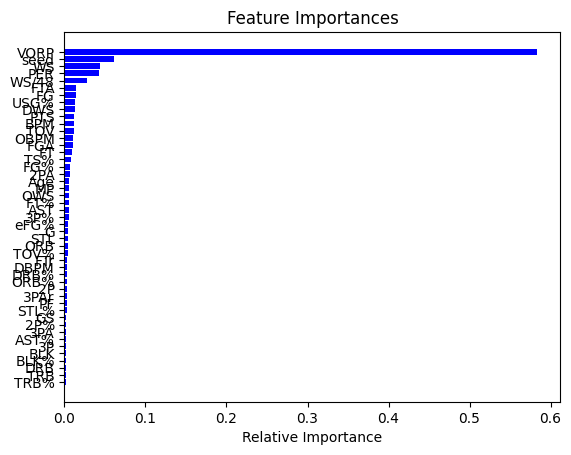

In [229]:
importances = regressor.feature_importances_

# then sort them descending
indices = np.argsort(importances)

# get the features from the original data set
features = combined.drop(["cons_mvp","mvp_votes","Rk","season","Player","team"],axis=1).columns

# plot them with a horizontal bar chart
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

In [230]:
def last(arr):
    return arr[-1]
list=[]
for i,v in enumerate(importances):
    list.append([features[i],v])
list=(sorted(list,reverse=True,key=last))
for i in list:
    print(i)

['VORP', 0.5831125088606322]
['seed', 0.06124452673415073]
['WS', 0.04353570946952273]
['PER', 0.042907701269088105]
['WS/48', 0.0278040635791531]
['FTA', 0.014748379329915916]
['FG', 0.013737378885885918]
['USG%', 0.013460801248501506]
['DWS', 0.013046785663315387]
['PTS', 0.01234669905057818]
['BPM', 0.011547142200058808]
['TOV', 0.011482697268097752]
['OBPM', 0.011030254523901708]
['FGA', 0.010210941214237126]
['FT', 0.009582427788005944]
['TS%', 0.007442486986860567]
['FG%', 0.006821719585877389]
['2PA', 0.006519052402552807]
['Age', 0.00620484934050282]
['MP', 0.0060172439035843794]
['OWS', 0.005775401664464459]
['FT%', 0.005768666105612342]
['AST', 0.005346113615294185]
['3P%', 0.0050720119261806395]
['eFG%', 0.004926972399938875]
['G', 0.004550603353314205]
['STL', 0.004265104070001037]
['ORB', 0.004191072836383682]
['TOV%', 0.003751483280485848]
['FTr', 0.0033979155893485865]
['DBPM', 0.0033700033382617544]
['DRB%', 0.0032323860275130117]
['ORB%', 0.0029706980390947417]
['2P', 